# Исследование методов классификации данных с помощью нейронной сети

Дисциплина: "**Системы поддержки принятия решений**"

**Подготовил**: Лосев А. П., гр. ИСТ-131м, **вариант 6**.

Метод оптимизации — **SGD**, число нейронов в скрытом слое — **20**, шаг градиентного спуска — **0,01**.

**Принял**: Литвинов В. Л.

Импорт необходимых зависимостей:

In [1]:
import torch
import random
import numpy as np

Создание *random seed* и установление для него конкретного значения:

In [2]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

Импорт датасета вин для анализа размеченных данных:

In [3]:
import sklearn.datasets
wine = sklearn.datasets.load_wine()
wine.data.shape

(178, 13)

Разделение датасета пополам и перемешивание данных в датасете, а также расчёт *base_rate*:

In [4]:
from sklearn.model_selection import train_test_split 
X_train, X_test, y_train, y_test = train_test_split(
          wine.data[:, :2],
    wine.target, 
    test_size=0.3, 
    shuffle=True) 
X_train = torch.FloatTensor(X_train) 
X_test = torch.FloatTensor(X_test) 
y_train = torch.LongTensor(y_train) 
y_test = torch.LongTensor(y_test)

base_rate = len(wine.target[wine.target==1])/len(wine.target)
print('Base rate is', base_rate)

Base rate is 0.398876404494382


Создание нейросети для классификации вин:

In [5]:
class WineNet(torch.nn.Module):
    def __init__(self, n_hidden_neurons):
        super(WineNet, self).__init__()
        
        self.fc1 = torch.nn.Linear(2, 20)
        self.activ1 = torch.nn.Sigmoid()
        #self.fc2 = torch.nn.Linear(20, 20)
        #self.activ2 = torch.nn.Sigmoid()
        self.fc3 = torch.nn.Linear(20, 3)
        self.sm = torch.nn.Softmax(dim=1)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.activ1(x)
        #x = self.fc2(x)
        #x = self.activ2(x)
        x = self.fc3(x)
        return x

    def inference(self, x):
        x = self.forward(x)
        x = self.sm(x)
        return x
    
wine_net = WineNet(5)

Расчёт оiибки и задание оптимайзера для нейронной сети:

In [6]:
loss = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(wine_net.parameters(), lr=1.0e-2)

Разбиение данных на батчи и обучение нейросети по эпохам:

In [7]:
%%time
batch_size = 10

for epoch in range(5000):
    order = np.random.permutation(len(X_train))
    for start_index in range(0, len(X_train), batch_size):
        optimizer.zero_grad()
        
        batch_indexes = order[start_index:start_index+batch_size]
        
        x_batch = X_train[batch_indexes]
        y_batch = y_train[batch_indexes]
        
        preds = wine_net.forward(x_batch) 
        
        loss_value = loss(preds, y_batch)
        loss_value.backward()
        
        optimizer.step()
        
    if epoch % 100 == 0:
        test_preds = wine_net.forward(X_test)
        test_preds = test_preds.argmax(dim=1)
        print((test_preds == y_test).float().mean())

tensor(0.3519)
tensor(0.4630)
tensor(0.4815)
tensor(0.4630)
tensor(0.4630)
tensor(0.4815)
tensor(0.5000)
tensor(0.6667)
tensor(0.7963)
tensor(0.6481)
tensor(0.8333)
tensor(0.7593)
tensor(0.7778)
tensor(0.7593)
tensor(0.7963)
tensor(0.6481)
tensor(0.5000)
tensor(0.7222)
tensor(0.7407)
tensor(0.7407)
tensor(0.8519)
tensor(0.8148)
tensor(0.6852)
tensor(0.6667)
tensor(0.6852)
tensor(0.8519)
tensor(0.8148)
tensor(0.6852)
tensor(0.4815)
tensor(0.8519)
tensor(0.7593)
tensor(0.8333)
tensor(0.8333)
tensor(0.4630)
tensor(0.6852)
tensor(0.8333)
tensor(0.7593)
tensor(0.6667)
tensor(0.6111)
tensor(0.8704)
tensor(0.8148)
tensor(0.8704)
tensor(0.6852)
tensor(0.8333)
tensor(0.4630)
tensor(0.8148)
tensor(0.6852)
tensor(0.8889)
tensor(0.7593)
tensor(0.8704)
CPU times: total: 2min 26s
Wall time: 36.7 s


Визуализация предсказаний для нейронной сети, созданной в данной работе:

C:\Users\Arseniy Losev\AppData\Local\Temp\ipykernel_20500\273158456.py:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:210.)
  plt.scatter(X_train[indexes, 0],


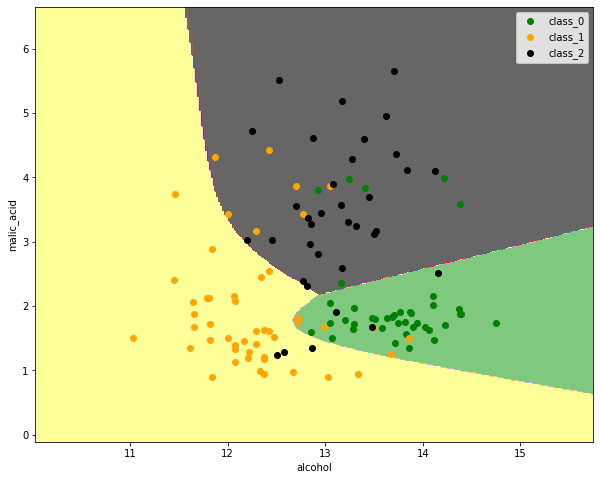

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['figure.figsize'] = (10, 8)

n_classes = 3
plot_colors = ['g', 'orange', 'black']
plot_step = 0.02

x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1

xx, yy =  torch.meshgrid(torch.arange(x_min, x_max, plot_step),
                         torch.arange(y_min, y_max, plot_step), indexing="xy")

preds = wine_net.inference(
    torch.cat([xx.reshape(-1, 1), yy.reshape(-1, 1)], dim=1))

preds_class = preds.data.numpy().argmax(axis=1)
preds_class = preds_class.reshape(xx.shape)
plt.contourf(xx, yy, preds_class, cmap='Accent')

for i, color in zip(range(n_classes), plot_colors):
    indexes = np.where(y_train == i)
    plt.scatter(X_train[indexes, 0], 
                X_train[indexes, 1], 
                c=color, 
                label=wine.target_names[i],
                cmap='Accent')
    plt.xlabel(wine.feature_names[0])
    plt.ylabel(wine.feature_names[1])
    plt.legend()

***
**Задание на лабораторную работу**
***

1. Изучить понятие кросс-энтропии и *Softmax*
2. Исследовать нейронную сеть при заданных начальных параметрах (см. таблицу). Найти минимальное значение n_hidden_neurons, при котором сеть дает неудовлетворительные результаты, т.е. обучение невозможно.
3.	Исследовать зависимость точности распознавания от количества нейронов в скрытом слое, количества слоев, метода активации.
4.	При каком значении *test_size* сеть предсказывает хуже, чем *Base Rate* (*BaseRate* –это вероятность самого многочисленного класса в исходных данных)? И какой *Base Rate* у датасета вин?
5.	Исследовать зависимость времени обучения от размера батча.

***
**Ответы на задание**
***

1. Кросс-энтропия — функция потерь, которая используется для оценки разности между распределениями вероятностей. *Softmax* — функция, используемая для трансформирования набора чисел в набор вероятностей, которые в сумме составляют единицу, и применяемая для классификации данных.
2. При выполнении **варианта 6** используются следующие параметры: метод оптимизации — **SGD**, число нейронов в скрытом слое — **20**, шаг градиентного спуска — **0,01**. При использовании **SGD**—метода заметны более интенсивные изменения значения *accuracy*, нежели при использовании метода **ADAM**. Данная нейронная сеть становится практически необучаемой, если гиперпараметр ***m_hidden_neurons*** становится равным **7**.
3. При неизменности прочих гиперпараметров, методы оптимизации **ADAM** и **SGD** эквивалентны между собой, потому как в первом случае *accuracy* составила **0,8519**, а во втором случае — **0,8704**. Увеличение количества нейронов от оптимального значения для варианта не дало существенного прироста для *accuracy*, однако их уменьшение сказалось на данном параметре в сторону уменьшения значения. Увеличение количества скрытых слоёв значительно снижает точность и увеличивает время работы кода.
4. Нейросеть предсказывает хуже, если параметр *test_size* имеет значение **0,037** и меньше. *Base Rate* для датасета вин составляет **0,3989**.
5. Размер батча обратно пропорционален времени обучения. При размере батча в **2** единицы обучение проводится за **3 минуты и 34 секунды**. При размере батча в **25** единиц обучение проводится за **14 секунд**. При размере батча в **10** единиц обучение проводится за **45 секунд**.

**Выводы**: при выполнении лабораторной работы были получены практические навыки работы с искуственной нейронной сетью, задания необходимой конфигурации гиперпараметров и архитектуры нейросети, использования различных алгоритмов оптимизации, добавления и удаления скрытых слоёв внутри нейросети, а также работы с датасетом реальных данных. Также были получены базовые навыки работы с данными, нуждающимися в классификации, а именно скремблированием данных с последующим считыванием. Нейронная сеть была в процессе работы сконфигурирована с расчётом на оптимальный режим работы обучения, с целью получения наибольшего коэффициента *accuracy* за наименьшее время. Для этого был проведён поиск оптимальных параметров размера бэтча, количества нейронов в скрытом слое, а также параметра *test_size*.